# Boundary value problems with FFT

In class, we saw a couple of methods to approximate BVPs using FFTs. Let's try them out now. Our model problem will be the Poisson equation

\begin{align}
\frac{\partial^2 u}{\partial x^2} &= \frac{4 (6 \cos(2x) + \cos(4 x) - 3)}{(\cos(2 x) - 3)^3}\\
u(0) &= u(2\pi) = 1
\end{align}

The analytical solution to this problem is

\begin{equation}
u(x) = \frac{1}{1+\sin^2(x)}
\end{equation}

## Finite difference and FFTs

Discretizing the above equation with finite differences for $N$ nodes, we get

\begin{equation}
\frac{u_{n-1}-2u_n+u_{n+1}}{h^2} = \frac{4 (6 \cos(2x) + \cos(4 x) - 3)}{(\cos(2 x) - 3)^3} = f(x)
\end{equation}

Representing $u_n$ in a Fourier expansion

\begin{equation}
u_n = \sum_{k=-\frac{N}{2}+1}^\frac{N}{2} U_k e^\frac{i2\pi kn}{N}
\end{equation}

we can rewrite $u_{n+1}$ and $u_{n-1}$ as

\begin{align}
u_{n+1} = \sum_{k=-\frac{N}{2}+1}^\frac{N}{2} U_k e^\frac{i2\pi kn}{N} e^\frac{i2\pi k}{N}\\
u_{n-1} = \sum_{k=-\frac{N}{2}+1}^\frac{N}{2} U_k e^\frac{i2\pi kn}{N} e^{-\frac{i2\pi k}{N}}.
\end{align}

and also,

\begin{equation}
f_n = \sum_{k=-\frac{N}{2}+1}^\frac{N}{2} F_k e^\frac{i2\pi kn}{N}
\end{equation}

Replacing these expressions in the discretized equation and factorizing, we get

\begin{equation}
\sum_{k=-\frac{N}{2}+1}^\frac{N}{2}\left[ U_k e^\frac{i2\pi kn}{N} \left( e^\frac{i2\pi k}{N} - 2 + e^{-\frac{i2\pi k}{N}} \right) \right] = h^2 \sum_{k=-\frac{N}{2}+1}^\frac{N}{2} F_k e^\frac{i2\pi kn}{N}
\end{equation}

But

\begin{equation}
 e^\frac{i2\pi k}{N} + e^{-\frac{i2\pi k}{N}} = 2\cos\left(\frac{2\pi k}{N}\right)
\end{equation}

which makes the previous expression 

\begin{equation}
\sum_{k=-\frac{N}{2}+1}^\frac{N}{2}\left[ U_k e^\frac{i2\pi kn}{N} 2\left( \cos\left(\frac{2\pi k}{N}\right) - 1 \right) \right] = h^2 \sum_{k=-\frac{N}{2}+1}^\frac{N}{2} F_k e^\frac{i2\pi kn}{N}
\end{equation}

Then, for each $k$

\begin{align}
2U_k & \left( \cos\left(\frac{2\pi k}{N}\right) - 1 \right) = h^2 F_k\\
\Rightarrow U_k &= \frac{h^2 F_k}{2\left( \cos\left(\frac{2\pi k}{N}\right) - 1 \right)}
\end{align}

and we can obtain $u(x)$ with an inverse FFT. 

## What about boundary conditions?
By using an FFT-based method, implicitly you are saying that the function is periodic, but so far, we just have the value up to a linear function (as it is a Poisson problem and the second derivative of a linear function is zero). There are two ways to include boundary conditions:

   1. Use an interpolant that accomplishes the boundary conditions
   2. Add a (linear or constant) function that accomplishes with the BCs
   
In our case, the inverse DFT at $n=0$ is not necessarily equal to 0, then, we need to add $\Delta u = 1-u(0)$ to the final result. 

Let's try this out!

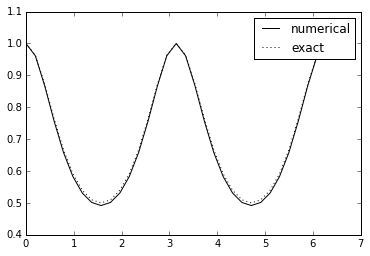

In [39]:
import numpy
import numpy.fft
import scipy.fftpack
from matplotlib import pyplot
from math import pi
%matplotlib inline

def function_0(x):
    return (4*(6*numpy.cos(2*x) + numpy.cos(4*x) - 3))/(numpy.cos(2*x) - 3)**3
        
def function_0_exact(x):
    return 1./(1.+numpy.sin(x)**2)
        
def solve_poisson(x, h, N, RHS_function):

    f = RHS_function(x)
    
    F_k = numpy.fft.fft(f)

    k = numpy.arange(1,N)

    U_k = numpy.zeros(N, dtype=complex)
    U_k[1:] = h**2*F_k[1:]/(2*(numpy.cos(2*pi*k/N)-1))

    n = numpy.arange(N)
    F_0_2prime = numpy.sum(-(2*pi*n/N)**2*f)


    U_k[0] = -h**2 * F_0_2prime/(8*pi**2/N**2) 

    u = numpy.fft.ifft(U_k) # u up to an additive constant or linear function

    f_add = 1-u[0]
    u += f_add
    
    return u
     

N = 32

xmin = 0.
xmax = 2*pi

h = (xmax-xmin)/(N)

x = numpy.linspace(xmin, xmax, N, endpoint=False)

u = solve_poisson(x, h, N, function_0)

u_exact = function_0_exact(x)

pyplot.plot(x, u, c='k', ls='-', label='numerical')
pyplot.plot(x, u_exact, c='k', ls=':', label='exact')
pyplot.legend(loc='best')

Let's look at the convergence

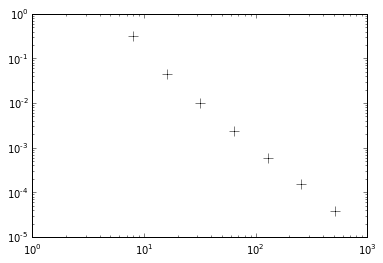

In [40]:
def L2_error(f, f_exact):
    return numpy.sqrt(numpy.sum((f-f_exact)**2)/numpy.sum(f_exact**2))

def convergence_test(N_array, function, function_exact, xmin, xmax):

    error = numpy.array([])
    for N in N_array:
     
        h = (xmax-xmin)/(N)
        x = numpy.linspace(xmin, xmax, N, endpoint=False)
        
        u = solve_poisson(x, h, N, function)
        
        u_exact = function_exact(x)
        
        e = L2_error(u, u_exact)
    
        error = numpy.append(error,e)    

    pyplot.loglog(N_array, error, ls='', marker='+', c='k', ms=10)

xmin = 0.
xmax = 2*pi

N_array = numpy.array([8, 16, 32, 64, 128, 256, 512])
convergence_test(N_array, function_0, function_0_exact, xmin, xmax)

As expected, we see second order convergence from the finite difference scheme.

What if we use an interpolant that accomplishes the BCs? Let's try

\begin{align}
-\frac{\partial^2 u}{\partial x^2} + \sigma^2u = 4x\sin(4x)-\cos(4x)\\
u(0) = u(\pi) = 0
\end{align}

with $\sigma = 4$, which has the following analytical solution

\begin{equation}
u(x) = \frac{1}{8}x\sin(4x)
\end{equation}

We know that the sine function is zero at $0$ and $\pi$. Let's use the discrete sine transform then!
The way it's implemented in scipy, the type I DST is (see [scipy.fftpack.dst](https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.fftpack.dst.html#scipy.fftpack.dst))

\begin{equation}
F_k = 2\sum_{n=0}^{N-1} f_n\sin\left(\frac{\pi(k+1)(n+1)}{N+1}\right)
\end{equation}

and its inverse is

\begin{equation}
f_n = \frac{1}{N-1}\sum_{k=0}^{N-1} F_k\sin\left(\frac{\pi(k+1)(n+1)}{N+1}\right)
\end{equation}

Note that the sine transform is equivalent to a $2N$ DFT, which is odd around the middle point (see the [Wikipedia article](https://en.wikipedia.org/wiki/Discrete_sine_transform) on this). Then, we could compute it in $O(N\log N)$ time with an FFT.

In this example problem, there is an extra $\sigma^2u$ which we are not used to with Poisson. This equation is known as the Helmhotlz equation, which is very useful to model scattering problems. The same derivation as before considering now Helmholtz and the sine transform, leads to the following relation between $U_k$ and $F_k$:

\begin{equation}
U_k = \frac{h^2F_k}{2\left(1-\cos\left(\frac{\pi(k+1)}{N+1}\right)\right)+\sigma^2h^2}
\end{equation}

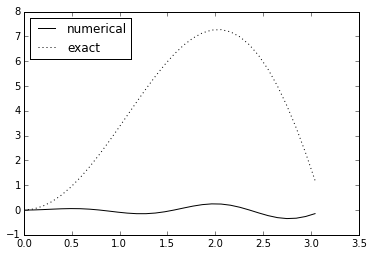

In [41]:

N = 32

xmin = 0.#-1.
xmax = numpy.pi#1.

h = (xmax-xmin)/(N)

x = numpy.linspace(xmin, xmax, N, endpoint=False)

#f = numpy.exp(4*x)
f = 4*x*numpy.sin(4*x) - numpy.cos(4*x)

#F_k = numpy.fft.fft(f)
F_k = scipy.fftpack.dst(f, type=1)

k = numpy.arange(N)

#U_k = h**2*F_k/(2*(numpy.cos(2*numpy.pi*k/N)-1))
U_k = h**2*F_k/(2*(1-numpy.cos(numpy.pi*(k+1)/(N+1)))+4**2*h**2) 

#u = numpy.fft.ifft(U_k)
u = scipy.fftpack.idst(U_k, type=1)*1./(2*(N+1))

#u_exact = 1./16*(numpy.exp(4*x) - numpy.sinh(4)*x - numpy.cosh(4))
u_exact = 4.*x*numpy.sin(x)

#test = scipy.fftpack.idst(U_k, type=1)*1./(2*(N+1))
#pyplot.plot(x, f, c='k', ls='-', label='f')
#pyplot.plot(x, test, c='k', ls=':', label='test')
#pyplot.legend(loc='best')

pyplot.plot(x, u, c='k', ls='-', label='numerical')
pyplot.plot(x, u_exact, c='k', ls=':', label='exact')
pyplot.legend(loc='best')

Something is wrong here, need to debug

## Spectral method

We saw previously that we can approximate derivatives using an inverse DFT representation of the function, which had spectral accuracy. Let's use that same principle to solve the first problem above

\begin{align}
\frac{\partial^2 u}{\partial x^2} &= f(x) = \frac{4 (6 \cos(2x) + \cos(4 x) - 3)}{(\cos(2 x) - 3)^3}\\
u(0) &= u(2\pi) = 1
\end{align}

Considering that the inverse DFT of $u$ is

\begin{equation}
u_n = \sum_{k=0}^{N-1} U_k e^{\frac{i2\pi kn}{N}}
\end{equation}

we can represent its second derivative as

\begin{equation}
u^{\prime\prime}_n = \sum_{k=0}^{N-1} -k^2U_k e^{\frac{i2\pi kn}{N}}
\end{equation}

Then, we can rewrite the above PDE as

\begin{equation}
\sum_{k=0}^{N-1} -k^2U_k e^{\frac{i2\pi kn}{N}} = \sum_{k=0}^{N-1} F_k e^{\frac{i2\pi kn}{N}}
\end{equation}

and, for each $k$

\begin{align}
-k^2U_k &= F_k
\Rightarrow U_k = -\frac{F_k}{k^2}
\end{align}

This leads to a 3-step algorithm

   1. Compute the DFT of $f(x)$, $F_k$.
   2. Divide by $-k^2$ to obtain $U_k$.
   3. Compute $u$ with the inverse DFT.

As before, this gives us the solution up to a constant or linear function. To accomplish with the boundary conditions we need to add a function with zero second derivative.

Let's try this out!


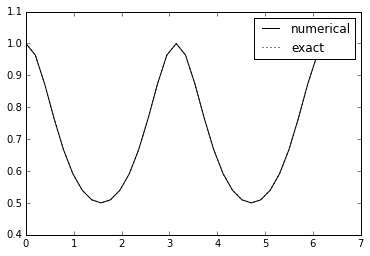

In [42]:
def solve_poisson_spectral(x, N, RHS_function):
    
    f = RHS_function(x)
    
    F_k = numpy.fft.rfft(f)
    
    k = numpy.arange(N/2+1)
    
    U_k = numpy.zeros(N/2+1, dtype=complex)
    U_k[1:] = -F_k[1:]/k[1:]**2
    
    n = numpy.arange(N)
    F_0_2prime = numpy.sum(-(2*pi*n/N)**2*f)
    
    U_k[0] = -F_0_2prime/2.
    
    u = numpy.fft.irfft(U_k) # u up to an additive constant or linear function

    f_add = 1-u[0]
    u += f_add
    
    return u

N = 32

xmin = 0.
xmax = 2*pi

x = numpy.linspace(xmin, xmax, N, endpoint=False)

u = solve_poisson_spectral(x, N, function_0)

u_exact = function_0_exact(x)

pyplot.plot(x, u, c='k', ls='-', label='numerical')
pyplot.plot(x, u_exact, c='k', ls=':', label='exact')
pyplot.legend(loc='best')

Looks good! Let's try to see the convergence

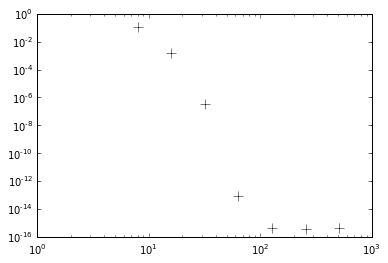

In [43]:
def convergence_test_spectral(N_array, function, function_exact, xmin, xmax):

    error = numpy.array([])
    for N in N_array:
     
        x = numpy.linspace(xmin, xmax, N, endpoint=False)
        
        u = solve_poisson_spectral(x, N, function)
        
        u_exact = function_exact(x)
        
        e = L2_error(u, u_exact)
    
        error = numpy.append(error,e)    

    pyplot.loglog(N_array, error, ls='', marker='+', c='k', ms=10)

xmin = 0.
xmax = 2*pi

N_array = numpy.array([8, 16, 32, 64, 128, 256, 512])
convergence_test_spectral(N_array, function_0, function_0_exact, xmin, xmax)

Spectral convergence!

### What about Chebyshev?

Let's now solve the following BVP

\begin{align}
\frac{\partial^2 u}{\partial x^2} &= e^{4x}\\
u(-1) &= u(1) = 0
\end{align}

which has the exact solution

\begin{align}
u=\frac{1}{16}\left(e^{4x} -\sinh(4)x-\cosh(4)\right)
\end{align}

As you can see, this is not a periodic function (which brings in the Runge phenomenon), and the boundary conditions say that the function is 0 at -1 and 1. There is something that can help us with both of those issues: the Chebyshev transform. The Chebyshev transform places points in such a way that oscillations are diminished, and the interpolant $(p(x) = T_n(\cos(\theta)) = \cos(n\theta))$ is $0$ at $\pm 1$, and the BCs are automatically satisfied. Moreover, we already learned how to approximate a derivative with Chebyshev transform using FFTs! 

We will use bits and pieces of that Chebyshev differentiation next. First, to perform the Chebyshev transformation and then its inverse

In [44]:
def cheb_trans_fft(function, x):
    
    N = len(x)
    f = function(x)
    f = numpy.ravel(f)
    ii = numpy.arange(N-1)
    K =  numpy.zeros(2*(N-1))
    K[0:N-1] = ii[:]
    K[N:2*(N-1)] = -numpy.flipud(ii[1:])
    y = numpy.append(f, numpy.flipud(f[1:N-1]))
    y_t = numpy.real(numpy.fft.fft(y))
    
    return y_t

def inverse_cheb_trans_fft(ddy_t, dy_t, x):
    """
    Computes the inverse cheb fft for a second derivative
    """
    N = len(x)
    ii = numpy.arange(N-1)
    w = numpy.zeros(N)
    w[1:N-1] = -ddy_t[1:N-1]/numpy.sqrt(1-x[1:N-1]**2)
    w[0] = numpy.sum(ii**2*dy_t[ii])/(N-1) + 0.5*(N-1)*dy_t[N-1]
    w[-1] = numpy.sum((-1)**(ii+1)*ii**2*dy_t[ii])/(N-1) + 0.5*(-1)**(N)*(N-1)*dy_t[N-1]
    
    return w

See that both of these functions together are the `chebfft_diff` from last class.

In [45]:
N = 32

xmin = -1.
xmax = 1.

x = numpy.linspace(xmin, xmax, N, endpoint=False)